# Homework Assignment 4
### The Art of Analyzing Big Data - The Data Scientist’s Toolbox 

In [37]:
import networkx as nx
import turicreate as tc
import json
from networkx.readwrite import json_graph
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Reddit Networks
Using the [Reddit networks dataset](http://dynamics.cs.washington.edu/nobackup/reddit/) select the subreddit of your favorite  TV show. Using the data of the selected subreddit, 
answer the following questions:

**Task 1:** Calculate and visualize the degree distribution  of the vertices  in the network (15pt)

In [12]:
#gtc=tc.load_sgraph('datasets/reddit/firefly/firefly.2010-01-07.2016-10-31.sgraph', format='binary')
gtc=tc.load_sgraph('datasets/fireTV/fireTV.2014-04-02.2014-04-30.sgraph', format='binary')

g = nx.Graph()
g.add_nodes_from(gtc.get_vertices()['__id'])
g.add_edges_from([(r['__src_id'],r['__dst_id']) for r in gtc.get_edges()])

ddf = pd.DataFrame(g.degree(),columns=['user','degree'])
ddf.sort_values('degree',ascending=False)

,user,degree
13,THECOACH0742,23
22,Tensuke,18
12,M0D1N,13
92,atomriot,12
43,tvIsMyJam,9
...,...,...
135,chrissurra,0
138,ximenez,0
139,tijiez,0
37,ahoslc,0


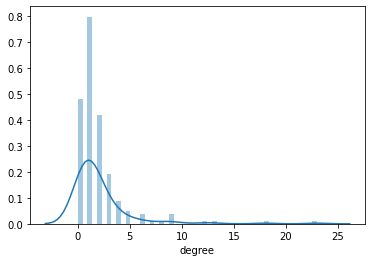

In [13]:
sns.distplot(ddf['degree'])

**Task 2:** Create a subgraph of the top-40 users according to a selected centrality algorithm. Draw the subgraph using circlular layout (15pt)

In [14]:
%%time
d_degree_centrality = pd.Series(nx.degree_centrality(g),name='centrality')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.16 ms


In [15]:
%%time
d_pagerank = pd.Series(nx.pagerank(g),name='centrality')


CPU times: user 46.9 ms, sys: 31.2 ms, total: 78.1 ms
Wall time: 48.1 ms


In [16]:
%%time
d_closeness_centrality = pd.Series(nx.closeness_centrality(g),name='centrality')

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 41.2 ms


In [42]:
d_degree_centrality.sort_values(ascending=False,inplace=True)
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 172\nNumber of edges: 174\nAverage degree:   2.0233'

In [43]:
g_pagerank_top40 = g.subgraph(d_degree_centrality[:40].index)

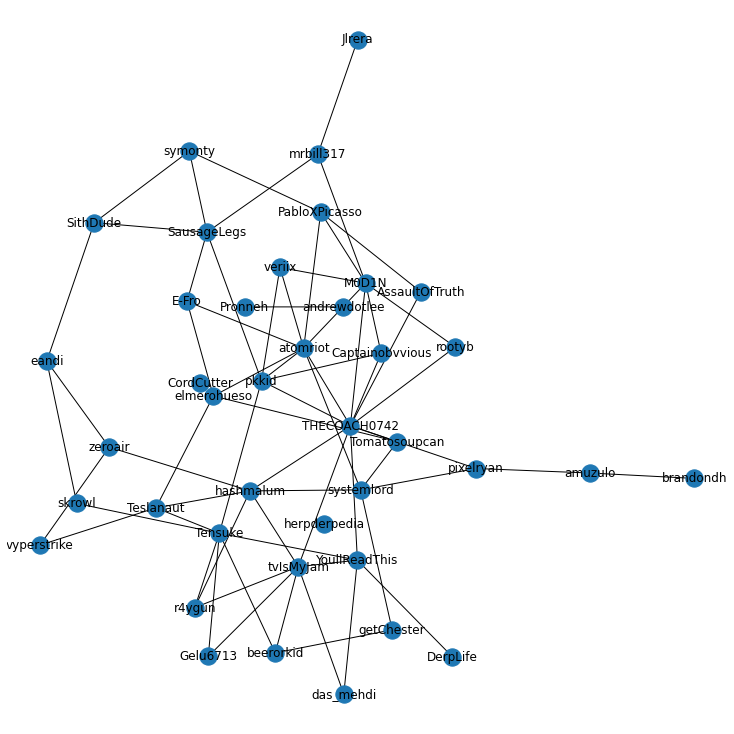

In [44]:
plt.figure(figsize=(10,10))
nx.draw_kamada_kawai(g_pagerank_top40, with_labels=True)

**Task 3:** Calculate the degree, triangles, and average shortest path of each vertex in the graph (15pt)

In [18]:
%%time
def graph_to_df(g):
    triangles = nx.triangles(g)
    df1 = pd.DataFrame(triangles.items(), columns=['user','triangles'])
    df1 = df1.set_index('user')
    degrees = g.degree()
    df2 = pd.DataFrame(triangles.items(), columns=['user','degree'])
    df2 = df2.set_index('user')
    return df1.join(df2)
df = graph_to_df(g)
df

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.5 ms


,triangles,degree
user,,
Electric_Alpaca,0,0
rootyb,1,1
legaxis,0,0
kastang,0,0
specialedster14,0,0
...,...,...
herpderpedia,0,0
toxichoe,1,1
RedditFuel,0,0


In [19]:
# It is not possible to compute the average shortest path of each vertex
# because the graph is not connected
# Let's see the sizes of connected components
component_sizes = []
for cc in nx.connected_components(g):
    component_sizes.append(len(cc))
from collections import Counter
counter = Counter(component_sizes)
counter

Counter({115: 1, 1: 38, 3: 1, 2: 3, 10: 1})

In [20]:
%%time
import numpy as np
from tqdm import tqdm
# We see that there is one main component and many small ones. Let's ignore the small ones
# and copy the main connected component into g_main
main_component = None
for cc in nx.connected_components(g):
    if len(cc) == max(list(counter.keys())):
        main_component = cc
        break
g_main = nx.Graph()
g_main.add_nodes_from(main_component)
edges = [(r['__src_id'],r['__dst_id']) for r in gtc.get_edges() \
         if r['__src_id'] in g_main and r['__dst_id'] in g_main ]
g_main.add_edges_from(edges)
graph_to_df(g_main)

CPU times: user 141 ms, sys: 219 ms, total: 359 ms
Wall time: 269 ms


,triangles,degree
user,,
just-some-person,0,0
E-Fro,1,1
esaba,0,0
g1no23,0,0
arthursoares,0,0
...,...,...
thehigherlife,0,0
mgriffioen,0,0
arturoaxtell,0,0


In [21]:
# compute the average_shortest_path_length for each vertex using a single process

# average_shortest_path_length = {}
# for node in tqdm(main_component):
#     aspl = np.mean(list(nx.shortest_path_length(g_main, node).values()))
#     average_shortest_path_length[node] = aspl

In [22]:
%%time
from tqdm import tqdm
# compute the average_shortest_path_length for each vertex in multi-processing
from multiprocessing import Pool

mc = list(main_component)
num_processors = 8
#Define a worker — a function which will be executed in parallel
def worker(x):
    average_shortest_path_length = {}    
    w_tqdm = tqdm if x == 0 else list
    for i in w_tqdm(range(x, len(mc), num_processors)):
        node = mc[i]
        aspl = np.mean(list(nx.shortest_path_length(g_main, node).values()))
        average_shortest_path_length[node] = aspl
    return average_shortest_path_length
#Create a pool of processors
p=Pool(processes = num_processors)
#get them to work in parallel
results = p.map(worker,[i for i in range(0,num_processors)])

100%|██████████| 15/15 [00:00<00:00, 1893.19it/s]


CPU times: user 15.6 ms, sys: 281 ms, total: 297 ms
Wall time: 410 ms


In [23]:
# Join it into the data frame
dfs = []
for res in results:    
    df1 = pd.DataFrame(res.items(), \
                       columns=['user','average_shortest_path_length'])
    df1 = df1.set_index('user')
    dfs.append(df1)
df_aspl = pd.concat(dfs)
df_final = df.join(df_aspl)
df_final

,triangles,degree,average_shortest_path_length
user,,,
Electric_Alpaca,0,0,4.113043
rootyb,1,1,3.182609
legaxis,0,0,NaN
kastang,0,0,NaN
specialedster14,0,0,NaN
...,...,...,...
herpderpedia,0,0,5.026087
toxichoe,1,1,3.373913
RedditFuel,0,0,4.139130


**Task 4:** Use Cytoscape and Gephi to visualize the network, where each vertex size is correlates to its degree (15pt)

In [31]:
attrs = {}
for node in g_main.nodes.keys():
    attrs[node] = {'degree': g_main.degree[node]}
nx.set_node_attributes(g_main, attrs)
nx.write_gml(g_main, "g_main.gml")

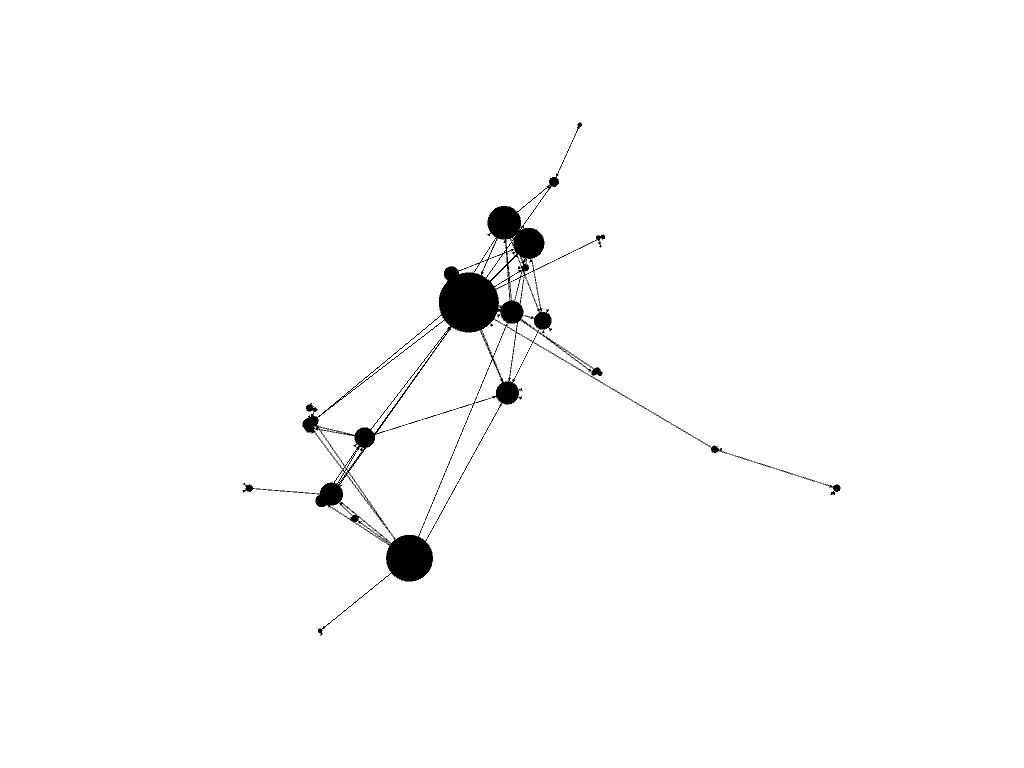

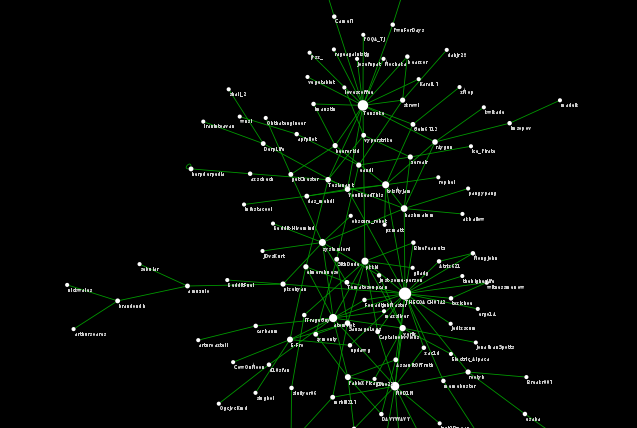

**Task 5:** Write a function that for a given vertex creates a subgraph of the selected vertex and all the vertex's in/out friends (10pt).
Draw the subgraph (5pt). Calculate the number of edges in the subgraph (5pt)

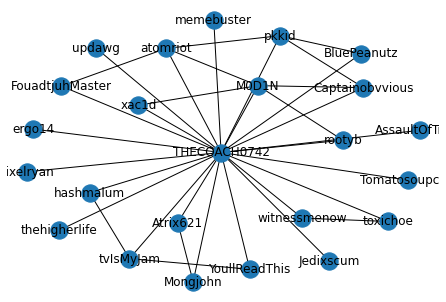

In [41]:
def create_sub_graph_from_vertex(vertex_id):
    sub_graph_nodes = set([vertex_id])
    for edge in gtc.get_edges():
        if edge['__src_id'] == vertex_id:
            sub_graph_nodes.add(edge['__dst_id'])
        if edge['__dst_id'] == vertex_id:
            sub_graph_nodes.add(edge['__src_id'])
    sub_graph = g_main.subgraph(sub_graph_nodes)
    return sub_graph

sub_graph = create_sub_graph_from_vertex('THECOACH0742')
nx.draw_kamada_kawai(sub_graph, with_labels=True)

**Task 6:** Find the top-10 most centeral players at [The Free Internet Chess Sever](http://dynamics.cs.washington.edu/nobackup/chess/fcis.tar.gz) (15 pt). Visualize part of the network (5pt).
    
**Note:** The network has 429,747,476 edges

In [2]:
v_sf = tc.load_sframe("./datasets/fcis/FCIS/fcis_chess.vertices.sframe")
l_sf = tc.load_sframe("./datasets/fcis/FCIS/fcis_chess.interactions.sframe")

In [3]:
sg = tc.SGraph(vertices=v_sf, edges=l_sf, vid_field="v_id", src_field="src_id", dst_field="dst_id")
# sg.summary()

In [5]:
%%time
pr = tc.pagerank.create(sg)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 632166                |

| 2         | 180728                |

| 3         | 68816.1               |

| 4         | 37065.1               |

| 5         | 22362.9               |

| 6         | 14085.1               |

| 7         | 9275.28               |

| 8         | 6324.12               |

| 9         | 4374.45               |

| 10        | 3129.99               |

| 11        | 2241.2                |

| 12        | 1641.8                |

| 13        | 1201.78               |

| 14        | 891.069               |

| 15        | 660.813               |

| 16        | 493.889               |

| 17        | 369.505               |

| 18        | 277.958               |

| 19        | 209.503               |

| 20        | 158.656               |

+-----------+-----------------------+

CPU times: user 14min 42s, sys: 24.3 s, total: 15min 6s
Wall time: 3min 52s


In [10]:
sg.vertices['pagerank'] = pr['graph'].vertices['pagerank']

In [26]:
top_pagerank=sg.vertices.sort('pagerank',ascending=False)['__id'][:20]

In [27]:
print('Top 10 by PageRank: ',top_pagerank[:10])

Top 10 by PageRank:  ['inemuri', 'mscp', 'GriffySr', 'GriffyJr', 'IFDThor', 'callipygian', 'parrot', 'MiloBot', 'BabyLurking', 'LuigiBot']


In [36]:
sg.edges.filter_by(top_pagerank,'__src_id').filter_by(top_pagerank,'__dst_id')

__src_id,__dst_id,datetime
GriffySr,GriffyJr,2010-01-11 08:08:00
GriffyJr,GriffySr,2010-01-11 08:08:00
GriffyJr,GriffySr,2010-01-11 08:16:00
GriffySr,GriffyJr,2010-01-11 08:16:00
GriffySr,GriffyJr,2010-01-12 22:25:00
GriffyJr,GriffySr,2010-01-12 22:25:00
GriffySr,GriffyJr,2010-01-12 23:08:00
GriffyJr,GriffySr,2010-01-12 23:08:00
GriffyJr,GriffySr,2010-01-12 23:19:00
GriffySr,GriffyJr,2010-01-12 23:19:00


In [40]:
top_pagerank_graph = tc.SGraph(
    vertices=sg.vertices.filter_by(top_pagerank,'__id'),
    edges=sg.edges.filter_by(top_pagerank,'__src_id').filter_by(top_pagerank,'__dst_id'),
    vid_field="__id", src_field="__src_id", dst_field="__dst_id"
)

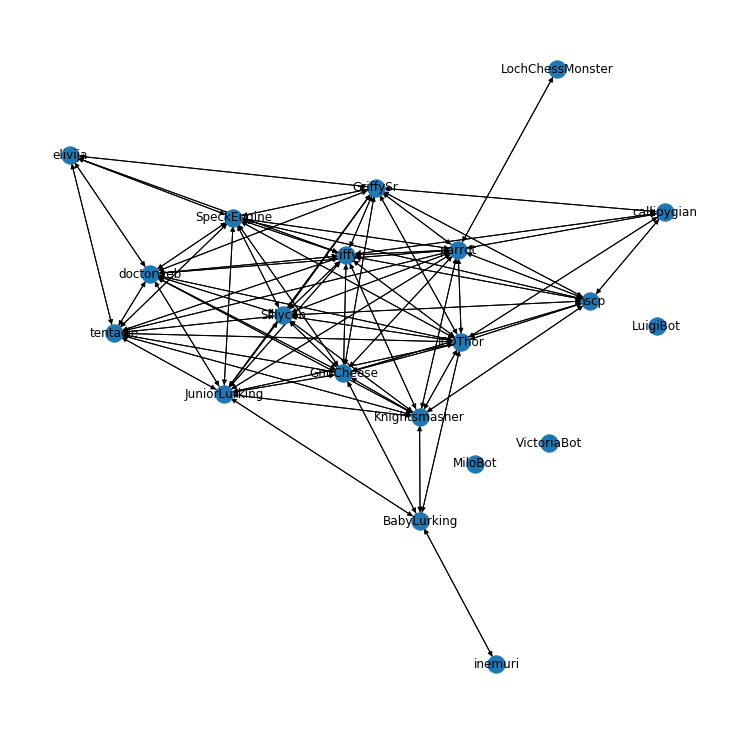

In [44]:
top_pagerank_nx = nx.Graph()
top_pagerank_nx.add_nodes_from(top_pagerank_graph.get_vertices()['__id'])
top_pagerank_nx.add_edges_from([(r['__src_id'],r['__dst_id']) for r in top_pagerank_graph.get_edges()])

top_pagerank_ng = sgraph2nxgraph(top_pagerank_graph)
plt.figure(figsize=(10,10))
nx.draw_kamada_kawai(top_pagerank_ng, with_labels=True)

**Task 7:** Use Cytoscape to draw the Lord of the Rings Couples network (see Lecture 2).
Fill the network's vertices in a different color according to the gender.
Select each vertex shape to be according to the vertex race. (7pt)

In [46]:
# Creating a dataset directory
!cd /content
!mkdir ./datasets/ltor
!cd ./datasets/ltor

# download the dataset from Kaggle and unzip it
!kaggle datasets download paultimothymooney/lord-of-the-rings-data  -p ./datasets/ltor
!unzip ./datasets/ltor/*.zip  -d ./datasets/ltor
!ls ./datasets/ltor

/bin/sh: 1: cd: can't cd to /content
/bin/sh: 1: kaggle: not found
/bin/sh: 1: unzip: not found


In [47]:
import re 
import numpy as np
import pandas as pd
import networkx as nx

df = pd.read_csv("./datasets/ltor/lotr_characters.csv")
df = df.fillna('')
df

,birth,death,gender,hair,height,name,race,realm,spouse
0,,,Female,,,Adanel,Men,,Belemir
1,TA 2978,"February 26 ,3019",Male,Dark (book) Light brown (movie),,Boromir,Men,,
2,,"March ,3019",Male,,,Lagduf,Orcs,,
3,TA 280,TA 515,Male,,,Tarcil,Men,Arnor,Unnamed wife
4,,,Male,,,Fire-drake of Gondolin,Dragon,,
...,...,...,...,...,...,...,...,...,...
906,"Mid ,First Age",FA 495,Female,,,Aerin,Men,,Brodda
907,,,,,,Aerandir,,,
908,"YT during the ,Noontide of Valinor",FA 455,Male,Golden,,Aegnor,Elves,,"Loved ,Andreth but remained unmarried"
909,TA 2917,TA 3010,Male,,,Adrahil II,Men,,Unnamed wife


In [48]:
g = df.groupby(['race', 'gender'])
#g.size()# create a Series 
g.size().to_frame (name='counts').sort_values('counts', ascending=0)

,,counts
race,gender,
Men,Male,334
,,137
Hobbits,Male,89
Elves,Male,76
Men,Female,51
...,...,...
Dragon,Male,1
Black Uruk,Male,1
Hobbits,male,1


In [49]:
import re
def normailze_spouse(s):
    if s in {'','Unnamed wife', 'None' }:
        return None
    if "Loved" not in s:
        return s
    
    r = re.compile("Loved ,(\w+)")
    l = r.findall(s)
    if len(l) > 0:
        return l[0]
df['norm_spouse'] = df['spouse'].apply(lambda s: normailze_spouse(s))
    
links_df = df[['name', 'norm_spouse', 'race', 'gender']]
links_df = links_df.dropna()
links_df


,name,norm_spouse,race,gender
0,Adanel,Belemir,Men,Female
7,Angrod,Eldalótë,Elves,Male
10,Ar-Pharazôn,Tar-Míriel,Men,Male
12,Ar-Gimilzôr,Inzilbêth,Men,Male
21,Tarannon Falastur,Berúthiel,Men,Male
...,...,...,...,...
897,Ailinel,Orchaldor,Men,Female
898,Almarian,Tar-Meneldur,Men,Female
899,Algund,None known,Men,Male
906,Aerin,Brodda,Men,Female


In [50]:
links_df2 = pd.merge(links_df, links_df, left_on="name", right_on="norm_spouse")
links_df2

,name_x,norm_spouse_x,race_x,gender_x,name_y,norm_spouse_y,race_y,gender_y
0,Adanel,Belemir,Men,Female,Belemir,Adanel,Men,Male
1,Angrod,Eldalótë,Elves,Male,Eldalótë,Angrod,Elves,Female
2,Ar-Pharazôn,Tar-Míriel,Men,Male,Tar-Míriel,Ar-Pharazôn,Men,Female
3,Ar-Gimilzôr,Inzilbêth,Men,Male,Inzilbêth,Ar-Gimilzôr,Men,Female
4,Tarannon Falastur,Berúthiel,Men,Male,Berúthiel,Tarannon Falastur,Men,Female
...,...,...,...,...,...,...,...,...
122,Amroth,Nimrodel,Elves,Male,Nimrodel,Amroth,Elves,Female
123,Amarië,Finrod,Elves,Female,Finrod,Amarië,Elves,Male
124,Ailinel,Orchaldor,Men,Female,Orchaldor,Ailinel,Men,Male
125,Almarian,Tar-Meneldur,Men,Female,Tar-Meneldur,Almarian,Men,Male


In [51]:
links_df2 = links_df2[["name_x","race_x", "gender_x", "name_y", "race_y", "gender_y"]]
links_df2

,name_x,race_x,gender_x,name_y,race_y,gender_y
0,Adanel,Men,Female,Belemir,Men,Male
1,Angrod,Elves,Male,Eldalótë,Elves,Female
2,Ar-Pharazôn,Men,Male,Tar-Míriel,Men,Female
3,Ar-Gimilzôr,Men,Male,Inzilbêth,Men,Female
4,Tarannon Falastur,Men,Male,Berúthiel,Men,Female
...,...,...,...,...,...,...
122,Amroth,Elves,Male,Nimrodel,Elves,Female
123,Amarië,Elves,Female,Finrod,Elves,Male
124,Ailinel,Men,Female,Orchaldor,Men,Male
125,Almarian,Men,Female,Tar-Meneldur,Men,Male


In [52]:
g = nx.Graph()

for i, r in links_df2.iterrows():
    g.add_node(r['name_x'],race=r["race_x"], gender=r["gender_x"])
    g.add_node(r['name_y'],race=r["race_y"], gender=r["gender_y"])
    edges_list = [(r['name_x'], r['name_y']) for i, r in links_df2.iterrows()]

g.add_edges_from(edges_list)

In [53]:
nx.write_gml(g, "lord.gml")

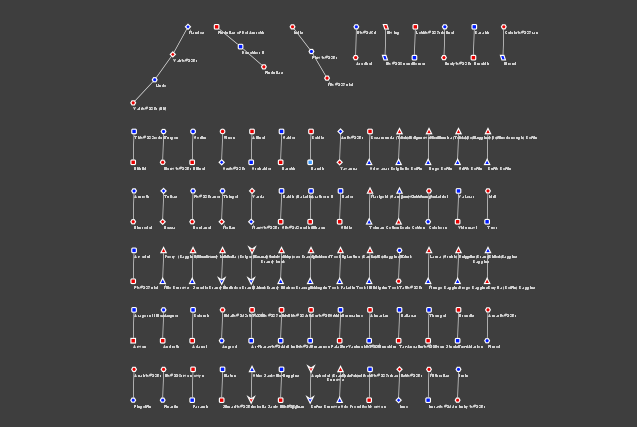

### Additional Questions for Practice

**Task 1:** Visualize the distribution of the network's strongly and weakly connected components.

**Task 2:** Using Cytoscape, visualize the network's maximal strongly connected component (or part of it)

**Task 3:** Draw a subgraph of all the vertices that have at least one reciprocal link, i.e., all the vertices where there is at least one vertex _u_ so that both links (u,v) and (v,u) exists

**Task 4:** Split the network into communities, and find the second most central vertex in each community
    

**Task 5:** Find the top-10 most central players at [The Free Internet Chess Server](http://dynamics.cs.washington.edu/nobackup/chess/fcis.tar.gz).
    Visualize part of the network.
    
**Note:** The network has 429,747,476 edges